# Fonction Pseudo-booléenne vers hamiltonian de coût pour QAOA 

Définison tout d'abord ce qu'est une fonction pseudo Booléenne. une fonction booléen normal prend la forme suivante : AB+BC+C(A!B) ceci voudrais dire "A et B OU B et C OU C et (A et NON B)" où chaque valeur A B C peuvent être soit "vrai" ou "faux". le résultat de la fonction est aussi "vrai" ou "faux".

une fonction pseudo-booléen est la même affaire, mais avec un coefficient imaginaire devant. par example : c<sub>0</sub>A-c<sub>1</sub>B*C où c<sub>k</sub> est un nombre imaginaire.

dans ce jupyter notebook, on va montrer comment transformer une fonction pseudo-booléen vers un hamiltonian de coût pour QAOA. cet hamiltonian peut après être pris pour trouver les valeus (A B C...) afin de minimiser les valeur de sorte à avoir le plus bas coût.

Tout d'abord, on définit une fonction qui prend en entrée une expression booléenne du genre :

"10\*A\*B+-10\*C+100\*!A"


où :

- `!` signifie **non** (négation),
- `+` signifie **ou** (disjonction),
- `*` signifie **et** (conjonction).

Cette fonction retourne une version de l'expression où les variables booléennes sont remplacées par des **projecteurs** quantiques.

---

On note :

- $ P_x = |x\rangle \langle x| $ est le projecteur sur l'état $ |x\rangle $,
- $ P_\tau |y\rangle = \delta_{\tau y} \, |y\rangle = y^\tau |y\rangle $  ($ y^\tau = 1 $ si $ y = \tau $, et 0 sinon).

Ainsi, on peut "remplacer" une variable booléenne $ A \in \{0,1\} $ par un projecteur $ P_A $, ce qui nous permet d'exprimer des fonctions booléennes comme des opérateurs agissant sur des états quantiques.

---

On utilise aussi le fait que, pour une base computationnelle $ |\vec{a}\rangle $, et une fonction booléenne $ f $, on a :

$$
\langle \vec{a} | f_H | \vec{a} \rangle = f(\vec{a})
$$

où $ f_H $ est l’opérateur (ou observable) représentant la fonction $ f $.

Autrement dit, appliquer $ f_H $ à un état $ |\vec{a}\rangle $ revient à multiplier cet état par la valeur $ f(\vec{a}) $.


In [2]:
import re
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa, AdamOptimizer, SPSAOptimizer, QNSPSAOptimizer, MomentumOptimizer, NesterovMomentumOptimizer, AdagradOptimizer, RMSPropOptimizer, RiemannianGradientOptimizer
from pennylane import *
import matplotlib.pyplot as plt

In [3]:
def bool_expr_to_hamiltonian(expr, var_to_wire):
    expr = expr.replace(' ', '')
    terms = re.findall(r'([+-]?\d+(?:\.\d+)?)\*?([A-Za-z!*]*)', expr)

    def parse_var(v):
        negated = v.startswith('!')
        var_name = v[1:] if negated else v
        wire = var_to_wire[var_name]
        return f'p({wire},{0 if negated else 1})'

    hamiltonian_terms = []

    for coeff, vars_str in terms:
        if vars_str == '':
            term_expr = f'{coeff}*qml.Identity(0)'
        else:
            vars_list = vars_str.split('*')
            term_expr = ' @ '.join(parse_var(v) for v in vars_list)
            term_expr = f'{coeff}*{term_expr}'

        hamiltonian_terms.append(term_expr)

    return ' + '.join(hamiltonian_terms)


la fonction bool_expr_to_hamiltonian transforme les valeur A B C ... en projecteur $P_1^{qubit\_nb}$ et les valeur !A !B !C ... en projecteur $P_0^{qubit\_nb}$

In [4]:
var_to_wire = {'A':0, 'B':1, 'C':2}

boolean_expression = "10*A*B+-10*C-100*!A"

hamiltonian_expr = bool_expr_to_hamiltonian(boolean_expression, var_to_wire)
hamiltonian_expr

'10*p(0,1) @ p(1,1) + -10*p(2,1) + -100*p(0,0)'

nous savons que $P_x^{n} = \frac{1}{2} \left( I^{n} + (-1)^x Z^{n} \right)$

où :

- $P_x^{n}$  est le projecteur sur l’état associé à $ x \in \{0,1\} $ sur le $ n $ ième qubits,
- $ I^{n}$ est l'opérateur identité sur le $ n $ ième qubits,
- $ Z^{n}$ est l'opérateur de Pauli-Z agissant sur le $ n $ ième qubits

voici la fonction qui définis le projecteur $P_x^{n}$ en python :


In [5]:
def p(wire,value):
    return (1/2)* (qml.Identity(wire)+((-1)**value)*qml.PauliZ(wire))

Notre chaine de charactère généré précedemment inclus l'appel à la fonction p(wire,value) qu'on vient de définir.
la porte identité et la porte pauliZ est implémenter avec pennylane. Le résultat: on peu généré notre hamiltonian de coût en utilisant la fonction eval de python. 

(la fonction eval est dangereuse niveau cybersecurité ! assurez-vous d'être sur du contenue de la chaine de charactère qui sera executer!)

In [6]:
H_cost = eval(hamiltonian_expr)
H_cost

(
    (5.0 * (I(0)
  + -1 * Z(0))) @ (0.5 * (I(1)
  + -1 * Z(1)))
  + -5.0 * (I(2)
  + -1 * Z(2))
  + -50.0 * (I(0)
  + 1 * Z(0))
)

Testons maintenant notre hamiltonien de coût avec QAOA !


## Utilisation de QAOA avec pennylane pour trouver les valeurs minimum à notre fonction pseudo booléenne

In [7]:
wires = range(len(var_to_wire)) # le nombre de qubits dans le circuit doit être aussi gros que le nombre de valeur booléen différentes!
dev = qml.device("lightning.qubit", wires=wires)

# Mixer Hamiltonian, on utilise x_mixer, c'est au goût
mixer_h = qaoa.x_mixer(wires)

In [8]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(alpha, mixer_h)

def circuit(params):
    for w in wires:
        qml.Hadamard(wires=w)
    for i in range(depth):
        qaoa_layer(params[i, 0], params[i, 1])

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(H_cost)

maintenant, c'est le temps d'appliquer l'hamiltonian de coût avec QAOA et voir la performance avec différents optimizer et simulateurs.

In [9]:
steps = 900
depth = 20
optimizer = AdamOptimizer()
params = np.random.uniform(0, np.pi, (depth, 2))
# Optimization loop
for i in range(steps):
    params = optimizer.step(cost_function, params)
    if i% 10 == 1:
        print(f'step {i} out of {steps}')

print("Optimal Parameters:")
print(params)
print("Optimal Energy:", cost_function(params))

c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane\measurements\measurements.py:275: PennyLaneDeprecationWarning: MeasurementProcess property return_type is deprecated and will be removed in version 0.42. Instead, please use isinstance for type checking directly.
  warnings.warn(


step 1 out of 900
step 11 out of 900
step 21 out of 900
step 31 out of 900
step 41 out of 900
step 51 out of 900
step 61 out of 900
step 71 out of 900
step 81 out of 900
step 91 out of 900
step 101 out of 900
step 111 out of 900
step 121 out of 900
step 131 out of 900
step 141 out of 900
step 151 out of 900
step 161 out of 900
step 171 out of 900
step 181 out of 900
step 191 out of 900
step 201 out of 900
step 211 out of 900
step 221 out of 900
step 231 out of 900
step 241 out of 900
step 251 out of 900
step 261 out of 900
step 271 out of 900
step 281 out of 900
step 291 out of 900
step 301 out of 900
step 311 out of 900
step 321 out of 900
step 331 out of 900
step 341 out of 900
step 351 out of 900
step 361 out of 900
step 371 out of 900
step 381 out of 900
step 391 out of 900
step 401 out of 900
step 411 out of 900
step 421 out of 900
step 431 out of 900
step 441 out of 900
step 451 out of 900
step 461 out of 900
step 471 out of 900
step 481 out of 900
step 491 out of 900
step 501 ou

investigation des méta paramètres utile pour SPSA

In [10]:
steps = 20
depth = 20
first_params = np.random.uniform(0, np.pi, (depth, 2))
lowest_energy = 0
bestmeta = {'a':0.0,'b':0.0}
# Optimization loop
for a in np.arange(0.630, 0.632, 0.001, dtype=float):
    for c in np.arange(0.35, 0.355, 0.001, dtype=float):
        optimizer = SPSAOptimizer(maxiter=steps,c=c, a=a)
        params = first_params
        for i in range(steps):
            params = optimizer.step(cost_function, params)
            if i% 10 == 1:
                print(f'step {i} out of {steps}')
        result = cost_function(params)
        if result < lowest_energy:
            bestmeta['a'] = a
            bestmeta['c'] = c
            lowest_energy = result
        print(f"Optimal Energy: {result} a:{a} c:{c}")
#print("Optimal Parameters:")
#print(params)
#print("Optimal Energy:", cost_function(params))
print(f"best meta params : {bestmeta} with lowest energy {lowest_energy}")

step 1 out of 20
step 11 out of 20
Optimal Energy: -62.350644515222214 a:0.63 c:0.35
step 1 out of 20
step 11 out of 20
Optimal Energy: -87.4486358014057 a:0.63 c:0.351
step 1 out of 20
step 11 out of 20
Optimal Energy: -71.21986720241861 a:0.63 c:0.352
step 1 out of 20
step 11 out of 20
Optimal Energy: -41.67743156662847 a:0.63 c:0.353
step 1 out of 20
step 11 out of 20
Optimal Energy: -54.231448920154314 a:0.63 c:0.354
step 1 out of 20
step 11 out of 20
Optimal Energy: -37.48317702414449 a:0.63 c:0.355
step 1 out of 20
step 11 out of 20
Optimal Energy: -6.586180030172906 a:0.631 c:0.35
step 1 out of 20
step 11 out of 20
Optimal Energy: -73.2048732093865 a:0.631 c:0.351
step 1 out of 20
step 11 out of 20
Optimal Energy: -78.11162370312601 a:0.631 c:0.352
step 1 out of 20
step 11 out of 20
Optimal Energy: -25.83364957271994 a:0.631 c:0.353
step 1 out of 20
step 11 out of 20
Optimal Energy: -57.049057223729385 a:0.631 c:0.354
step 1 out of 20
step 11 out of 20
Optimal Energy: -7.8349066

In [11]:
steps = 700
depth = 20
first_params = np.random.uniform(0, np.pi, (depth, 2))
lowest_energy = 0
# Optimization loop
a=0.631 # valeur trouver avec la cellule précédente
c=0.351 # valeur trouver avec la cellule précédente
optimizer = SPSAOptimizer(maxiter=steps, c=c, a=a)
params = first_params
for i in range(steps):
    params = optimizer.step(cost_function, params)
    if i% 10 == 1:
        print(f'step {i} out of {steps}')
print("Optimal Parameters:")
print(params)
print("Optimal Energy:", cost_function(params))


step 1 out of 700
step 11 out of 700
step 21 out of 700
step 31 out of 700
step 41 out of 700
step 51 out of 700
step 61 out of 700
step 71 out of 700
step 81 out of 700
step 91 out of 700
step 101 out of 700
step 111 out of 700
step 121 out of 700
step 131 out of 700
step 141 out of 700
step 151 out of 700
step 161 out of 700
step 171 out of 700
step 181 out of 700
step 191 out of 700
step 201 out of 700
step 211 out of 700
step 221 out of 700
step 231 out of 700
step 241 out of 700
step 251 out of 700
step 261 out of 700
step 271 out of 700
step 281 out of 700
step 291 out of 700
step 301 out of 700
step 311 out of 700
step 321 out of 700
step 331 out of 700
step 341 out of 700
step 351 out of 700
step 361 out of 700
step 371 out of 700
step 381 out of 700
step 391 out of 700
step 401 out of 700
step 411 out of 700
step 421 out of 700
step 431 out of 700
step 441 out of 700
step 451 out of 700
step 461 out of 700
step 471 out of 700
step 481 out of 700
step 491 out of 700
step 501 ou

In [12]:
steps = 70
depth = 20
optimizer = QNSPSAOptimizer()
params = np.random.uniform(0, np.pi, (depth, 2))
# Optimization loop
for i in range(steps):
    params = optimizer.step(cost_function, params)
    if i% 10 == 1:
        print(f'step {i} out of {steps}')

print("Optimal Parameters:")
print(params)
print("Optimal Energy:", cost_function(params))

C:\Users\Kuift\AppData\Local\Temp\ipykernel_29332\2989119606.py:7: UserWarning: step_and_cost() instead of step() is called when blocking is turned on, as the step-wise loss value is required by the algorithm.
  params = optimizer.step(cost_function, params)
c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane\workflow\_setup_transform_program.py:56: UserWarning: A dynamic_one_shot transform already exists in the preprocessing program of the device. Therefore, the dynamic_one_shot applied on the qnode will be ignored. See https://docs.pennylane.ai/en/stable/code/api/pennylane.dynamic_one_shot.html for more information on the recommended way to use dynamic_one_shot.
  warnings.warn(


step 1 out of 70
step 11 out of 70
step 21 out of 70
step 31 out of 70
step 41 out of 70
step 51 out of 70
step 61 out of 70
Optimal Parameters:
[[ -9.27655889   8.72074044]
 [ 15.21784338  -5.5840187 ]
 [ 13.09363789   8.84057362]
 [  7.68359518  -8.62558334]
 [ -3.16268012   3.21819578]
 [ -0.25781605  -8.27656692]
 [-10.68394289 -10.80471309]
 [ 15.39050186 -16.22329621]
 [ 23.48493084  -5.45005344]
 [-13.77153617  11.97441676]
 [-20.83571875 -19.97059922]
 [-23.59729374   7.04181981]
 [-11.32419444  18.23000589]
 [ 26.80401664   1.56953131]
 [-20.71724631   6.73622042]
 [ 20.26977066  10.37892186]
 [-25.51174315   5.86679883]
 [  3.99142941 -17.93252328]
 [ -0.48498946  16.17035351]
 [  9.86723904  20.35706595]]
Optimal Energy: -102.4521907216809


In [13]:
from scipy.optimize import minimize
def cost_function_wrapper(params_flat):
    params_reshaped = params_flat.reshape(depth, 2)
    return cost_function(params_reshaped)
depth = 20
steps = 70
params_flat = np.random.uniform(0, np.pi, depth*2)
params = minimize(cost_function_wrapper, params_flat, method='BFGS',
                  options={'maxiter':steps}
                  ).x.reshape(depth, 2)

print("Optimal Parameters:")
print(params)
print("Optimal Energy:", cost_function(params))

Optimal Parameters:
[[ 2.27787268  2.25994533]
 [ 2.11864675  2.37724384]
 [ 0.22311921  2.538821  ]
 [ 3.06549418  1.33715896]
 [ 0.27764292  1.42063904]
 [ 2.83269005  2.62403138]
 [ 0.13297835  1.43704131]
 [ 2.49365649  0.12420298]
 [ 0.80588113  1.18285301]
 [ 2.70519833  2.10120661]
 [-0.27367188  0.68750129]
 [ 0.95957025  2.06586618]
 [ 1.30329353  1.48444449]
 [ 0.76693142  0.83633682]
 [ 2.47056478  0.75708498]
 [ 2.89079882  0.44175935]
 [ 2.08704073  0.98176051]
 [ 0.7982205   2.91913716]
 [ 2.48673993  1.67048355]
 [ 0.88473809  0.69080314]]
Optimal Energy: -109.99999999465058


In [14]:
from scipy.optimize import minimize
def cost_function_wrapper(params_flat):
    params_reshaped = params_flat.reshape(depth, 2)
    return cost_function(params_reshaped)
depth = 20
steps = 70
params_flat = np.random.uniform(0, np.pi, depth*2)
params = minimize(cost_function_wrapper, params_flat, method='COBYLA',
                  options={'maxiter':steps}
                  ).x.reshape(depth, 2)

print("Optimal Parameters:")
print(params)
print("Optimal Energy:", cost_function(params))

Optimal Parameters:
[[ 0.32855771 -0.02251141]
 [ 2.91237991  1.62592376]
 [ 1.62640197  2.59877074]
 [ 0.52102369  0.8732502 ]
 [ 0.66785846  2.87555321]
 [ 0.08023174  2.70467336]
 [ 1.64014237  1.1220841 ]
 [ 1.17984389  0.91624107]
 [ 0.96700975  1.02322186]
 [ 2.14935383  2.47317006]
 [ 0.71479847  1.67470836]
 [ 2.91095297  1.93778159]
 [ 0.03826192  1.84519609]
 [ 2.57788603  0.20020033]
 [ 0.91268057  2.11127532]
 [ 1.30746923  0.55144834]
 [ 1.6875118   2.61264619]
 [ 1.56800024  1.58176615]
 [ 0.0507882   0.94449485]
 [ 3.00586927  0.43167231]]
Optimal Energy: -104.1194370202098


In [15]:
from skopt import gp_minimize
from skopt.space import Real

def cost_function_wrapper(params_flat):
    params_reshaped = np.array(params_flat).reshape(depth, 2)
    return float(cost_function(params_reshaped))
result = gp_minimize(cost_function_wrapper, [Real(0, np.pi)] * (2 * depth), n_calls=25, random_state=42)
print("Optimal Parameters:", result.x)
print("Optimal Energy:", result.fun)
params = np.array(result.x).reshape(depth, 2)

c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane\measurements\measurements.py:275: PennyLaneDeprecationWarning: MeasurementProcess property return_type is deprecated and will be removed in version 0.42. Instead, please use isinstance for type checking directly.
  warnings.warn(
c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane\measurements\measurements.py:275: PennyLaneDeprecationWarning: MeasurementProcess property return_type is deprecated and will be removed in version 0.42. Instead, please use isinstance for type checking directly.
  warnings.warn(
c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane\measurements\measurements.py:275: PennyLaneDeprecationWarning: MeasurementProcess property return_type is deprecated and will be removed in version 0.42. Instead, please use isinstance for type checking directly.
  warnings.warn(
c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\si

Optimal Parameters: [2.273583390424183, 1.3403220980830186, 2.6619169832330547, 2.0313593682118194, 1.419011042021908, 1.6330456388600003, 2.486653343012844, 0.3239024758158926, 1.9949140414021205, 2.236604842194133, 1.5071605913324762, 1.1451663355877766, 2.015849756308864, 0.3822967604264008, 0.3566511360375893, 1.8201379303063652, 0.7583443188848664, 0.9710418760453289, 0.4568260667331515, 0.5172880581604694, 1.0809975598922275, 3.019822132146279, 1.6995242958736478, 1.5117873918020912, 0.4930736250340706, 1.2374459198634187, 2.8992344785577164, 0.45352461981106024, 1.1973514822883462, 2.6484927431244287, 1.0967854964302135, 2.7510127943494838, 1.0348621072041038, 2.9801881711782365, 0.3536168375865425, 0.8689436773071268, 1.5022245726356693, 0.6671005896372699, 1.656083898689152, 0.7776307463004665]
Optimal Energy: -98.38651184734942


In [16]:
steps = 70
depth = 20
optimizer = MomentumOptimizer()
params = np.random.uniform(0, np.pi, (depth, 2))
# Optimization loop
for i in range(steps):
    params = optimizer.step(cost_function, params)
    if i% 10 == 1:
        print(f'step {i} out of {steps}')

print("Optimal Parameters:")
print(params)
print("Optimal Energy:", cost_function(params))

step 1 out of 70


c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane\measurements\measurements.py:275: PennyLaneDeprecationWarning: MeasurementProcess property return_type is deprecated and will be removed in version 0.42. Instead, please use isinstance for type checking directly.
  warnings.warn(


step 11 out of 70
step 21 out of 70
step 31 out of 70
step 41 out of 70
step 51 out of 70
step 61 out of 70
Optimal Parameters:
[[  -30.68547786     5.65631795]
 [  204.53309971     4.68124012]
 [  112.78699503   -31.20785249]
 [-1210.49159321   -12.75249455]
 [  572.46828745    32.28336063]
 [-2385.01899502    82.413147  ]
 [  735.30814952    16.60770485]
 [  234.8077202     77.19219698]
 [ -706.18777094    13.84172251]
 [ -335.47245567    65.67235011]
 [-1114.36916899   -32.6548714 ]
 [  751.51080932    -2.68338988]
 [ -179.97635638    29.53307053]
 [  183.53889807    19.03207501]
 [ -943.55535107    56.23441862]
 [ 2610.77838719   -31.88722499]
 [-1163.04051867   -35.6114117 ]
 [  664.843457     -17.65469042]
 [-1815.44158431    -3.18718277]
 [-1258.29994527   -28.18317345]]
Optimal Energy: -52.35700102417265


In [17]:
import jax
import jax.numpy as jnp
from jaxopt import BFGS
steps = 70
depth = 20
def cost_function_wrapper(params_flat):
    params_reshaped = params_flat.reshape(depth, 2)
    return cost_function(params_reshaped)
# same thing but gpu
params_flat = np.random.uniform(0, np.pi, depth*2)
solver = BFGS(fun=cost_function_wrapper)
solution = solver.run(params_flat)

params = solution.params.reshape(depth, 2)
print("Optimal Parameters:")
print(params)
print("Optimal Energy:", cost_function(params))

c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane\workflow\resolution.py:74: RuntimeWarning: PennyLane is currently not compatible with versions of JAX > 0.4.28. You have version 0.5.3 installed.
  warn(


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 19.23534393310547 Stepsize:1.0  Decrease Error:19.23534393310547  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.4999999701976776  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 49.11085891723633 Stepsize:0.7499999403953552  Decrease Error:49.11085891723633  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 67.73609161376953 Stepsize:0.3749997317790985  Decrease Error:67.73609161376953  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 50.29734802246094 Stepsize:0.15849311649799347  

In [18]:
steps = 70
depth = 20
optimizer = QNGOptimizer()
params = np.random.uniform(0, np.pi, (depth, 2))
# Optimization loop
for i in range(steps):
    params = optimizer.step(cost_function, params)
    if i% 10 == 1:
        print(f'step {i} out of {steps}')

print("Optimal Parameters:")
print(params)
print("Optimal Energy:", cost_function(params))

step 1 out of 70
step 11 out of 70
step 21 out of 70
step 31 out of 70
step 41 out of 70
step 51 out of 70
step 61 out of 70
Optimal Parameters:
[[ 1.65667021e+00  2.78986903e+00]
 [ 2.22330547e+00  5.48037035e+00]
 [ 8.55669449e-01  1.86913992e+00]
 [ 1.65065819e+00  1.17969990e+00]
 [ 1.50688443e+00  2.60578189e+00]
 [ 1.37759474e-03  1.72748296e+00]
 [ 2.93234814e+00  3.13240483e-01]
 [ 3.50558038e-01  4.08436629e+00]
 [ 4.63336550e-02  3.57671131e+00]
 [ 2.45916999e+00  1.66548100e+00]
 [ 2.08715902e+00  2.41328382e+00]
 [ 8.02936317e-01  2.07133445e+00]
 [ 4.60060211e-01 -9.02331031e-01]
 [ 8.48523360e-01  2.00447179e+00]
 [ 1.72441365e+00 -6.67921782e-01]
 [ 2.16946289e-01  2.76986130e+00]
 [ 6.19130697e-01  1.83964940e+00]
 [ 3.02821782e+00  3.02707913e+00]
 [ 8.23958282e-02  4.05934048e+00]
 [ 1.18693050e+00  3.33726072e+00]]
Optimal Energy: -15.62522648123117


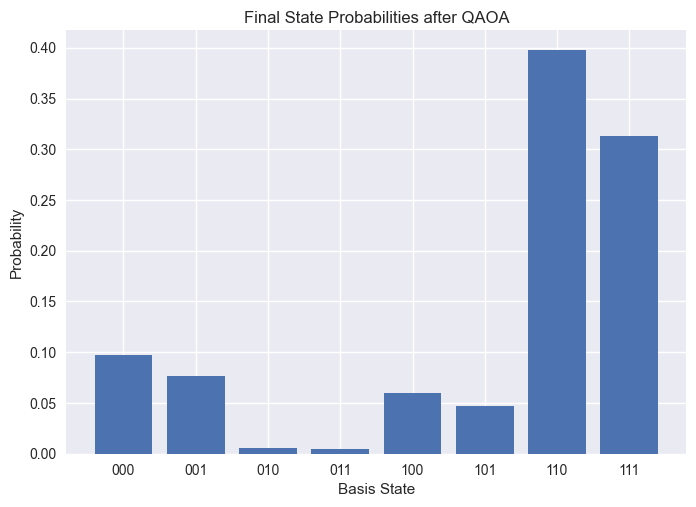

In [19]:
# Probability distribution of final state
@qml.qnode(dev)
def probability_circuit(params):
    circuit(params)
    return qml.probs(wires=wires)

probs = probability_circuit(params)

# Visualization
plt.style.use("seaborn-v0_8")
plt.bar(range(2 ** len(wires)), probs)
plt.xlabel('Basis State')
plt.ylabel('Probability')
plt.xticks(range(2 ** len(wires)), [f"{i:03b}" for i in range(2 ** len(wires))])
plt.title('Final State Probabilities after QAOA')
plt.show()

optimizer ranking with depth 20 and 70 steps and no noise: 

| Optimizer Name                                      | Avg Execution Time | Optimal Energy Found | Comment                                                                 |
|-----------------------------------------------------|---------------------|-----------------------|-------------------------------------------------------------------------|
| jax_BFGS                                            | 2m10s               | -109.97 Very reliable results              | supposedly only good in noiseless situations    |
| Adam                                                | 4.4s                | -108.55             |                                                                         |
| scipy_BFGS                                          | 1m3s                | -109.99 Very reliable results             |  supposedly only good in noiseless situations    |
| COBYLA                                              | 1.1s                | -96                   |                                                                         |
| gp_minimize (Bayesian optimization using GPs)       | 8.5s                | -98                   | Supposedly good in noisy situations                                     |
| QNSPSAOptimizer                                     | 38s                 | -95                   |                                                                         |
| SPSAOptimizer              | 14.5s               | -73  (very variable results)                  | Tuned meta parameter – supposedly good in noisy situations              |
| MomentumOptimizer                                   | 5s                  | -40 to -80 (variable) |                                                                         |
| QNGOptimizer                                        | 1m24s               | -41                   |                                                                         |


# Exemple d'une fonction booléenne intégrée dans une matrice et vérifié à la main
![Pseudo boolean mapping example](img/pseudo_boolean.jpg)

In [ ]:
import numpy as np
from functools import reduce

def bitstring_to_column_array(bitstring):
    """
    Converts a bitstring to a column NumPy array.

    Args:
        bitstring: The bitstring to convert.

    Returns:
        A column NumPy array representing the bitstring.
    """
    bit_list = [int(bit) for bit in bitstring]
    bit_array = np.array(bit_list)
    column_array = bit_array.reshape(-1, 1)
    return column_array

s1 = bitstring_to_column_array("10000000")
s2 = bitstring_to_column_array("00100000")
s3 = bitstring_to_column_array("00001000")
s4 = bitstring_to_column_array("00000100")
s5 = bitstring_to_column_array("00000010")
s6 = bitstring_to_column_array("00000001")
p_s_1 = s1*s1.T 
p_s_2 = s2*s2.T
p_s_3 = s3*s3.T
p_s_4 = s4*s4.T
p_s_5 = s5*s5.T
p_s_6 = s6*s6.T
print( p_s_1+p_s_2+2*p_s_3+p_s_4+3*p_s_5+2*p_s_6 )

ket0 = np.array([1, 0])
ket1 = np.array([0, 1])

p11 = np.outer(ket1, ket1)
p00 = np.outer(ket0, ket0)
iden2 = np.eye(2)

# helper
kron = lambda *mats: reduce(np.kron, mats)

term1 = kron(p11, iden2, iden2)          # |1⟩⟨1| ⊗ I ⊗ I₄
term2 = kron(iden2, iden2, p00)          # I ⊗ I₄ ⊗ |0⟩⟨0|
term3 = kron(np.kron(p11, p11), iden2)   # |11⟩⟨11| ⊗ I₄

result = term1 + term2 + term3           # each 8 × 8
print(result)